In [1]:
!pip install pyalex networkx ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.7 MB/s eta 0:00:00


Loading raw data from papers referencing social resilience

In [2]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import pyalex
import networkx as nx
import matplotlib.pyplot as plt
from pyalex import Works


def load_local_data(seed_path="seed_works.json", ref_path="reference_metadata.json"):
    """
    Loads the seed works and reference metadata JSON from local files.
    """
    with open(seed_path, "r", encoding="utf-8") as f:
        seed_works = json.load(f)
    with open(ref_path, "r", encoding="utf-8") as f:
        reference_metadata = json.load(f)
    return seed_works, reference_metadata

In [4]:
import ijson
import pandas as pd
import re
import gc

# File Locations
seed_works_loc = '/kaggle/input/social-resilience-data/seed_works.json'
reference_metadata_loc = '/kaggle/input/social-resilience-data/reference_metadata.json'

# Relevant Keywords (Regex Optimized)
RELEVANT_KEYWORDS = ['resilience']
KEYWORD_PATTERNS = [re.compile(rf"\b{re.escape(keyword)}\b", re.IGNORECASE) for keyword in RELEVANT_KEYWORDS]


def flatten_abstract(abstract_index):
    """
    Flatten OpenAlex 'abstract_inverted_index' into a plain text string.
    Ensures correct word order based on positions.
    """
    if not isinstance(abstract_index, dict):
        return ""

    position_word_map = []

    for word, positions in abstract_index.items():
        for position in positions:
            position_word_map.append((position, word))

    # Sort by position index
    position_word_map.sort()

    # Extract words in correct order
    return " ".join(word for _, word in position_word_map)


def is_paper_relevant(title, abstract, topics):
    """
    Validate if a paper is related to 'social resilience'
    based on title, abstract, and topics.
    """
    text_fields = " ".join(filter(None, [title, abstract] + topics)).lower()
    
    # Check for any keyword match
    return any(pattern.search(text_fields) for pattern in KEYWORD_PATTERNS)


def process_json_stream(file_path, source):
    """
    Efficiently loads and filters relevant JSON data using ijson streaming.
    """
    validated_papers = []
    unique_ids = set()

    with open(file_path, "r", encoding="utf-8") as f:
        objects = ijson.items(f, "item")  # Streams JSON array elements

        for obj in objects:
            paper_id = obj.get("id")
            if paper_id in unique_ids:
                continue  # Skip duplicates
            
            title = obj.get("title", "")
            year = obj.get("publication_year", "")
            abstract = flatten_abstract(obj.get("abstract_inverted_index", {}))
            topics = [c.get("display_name", "") for c in obj.get("topics", [])]
            refs = obj.get("referenced_works", [])

            if is_paper_relevant(title, abstract, topics):
                validated_papers.append({
                    "id": paper_id,
                    "title": title,
                    "publication_year": year,
                    "abstract": abstract,
                    "topics": topics,
                    "referenced_works": refs,
                    "source": source
                })
                unique_ids.add(paper_id)

            # Periodically free memory
            if len(validated_papers) >= 5000:
                yield validated_papers
                validated_papers = []
                gc.collect()

    # Return remaining batch
    if validated_papers:
        yield validated_papers
        gc.collect()


# ------------------------------------------------------------
# 1. Validate Papers from Seed Works
# ------------------------------------------------------------
validated_papers = []
for batch in process_json_stream(seed_works_loc, source="seed"):
    validated_papers.extend(batch)

print(f"Validated {len(validated_papers)} unique papers from seed works.")

# ------------------------------------------------------------
# 2. Validate Papers from Reference Metadata
# ------------------------------------------------------------
for batch in process_json_stream(reference_metadata_loc, source="reference"):
    validated_papers.extend(batch)

print(f"Validated {len(validated_papers)} unique papers in total (including references).")

# ------------------------------------------------------------
# 3. Convert to DataFrame and Deduplicate
# ------------------------------------------------------------
validated_df = pd.DataFrame(validated_papers)

# Final Deduplication
before_dedup = len(validated_df)
validated_df.drop_duplicates(subset="id", keep="first", inplace=True)
after_dedup = len(validated_df)

print(f"Removed {before_dedup - after_dedup} duplicate entries during final deduplication.")

# Save to CSV
validated_df.to_csv('validated_social_resilience_papers.csv', index=False)
print("Validated papers saved to 'validated_social_resilience_papers.csv'.")

# Clean Up Memory
del validated_papers
gc.collect()

# ------------------------------------------------------------
# 4. Display Sample of Validated Papers
# ------------------------------------------------------------
validated_df


Validated 16826 unique papers from seed works.
Validated 16826 unique papers in total (including references).
Removed 0 duplicate entries during final deduplication.
Validated papers saved to 'validated_social_resilience_papers.csv'.


,id,title,publication_year,abstract,topics,referenced_works,source
0,https://openalex.org/W628234387,The Vulnerability of Cities: Natural Disasters...,2005,When disaster strikes in cities the effects ca...,[Urban and Rural Development Challenges],[],seed
1,https://openalex.org/W2274815048,"Resilience, Adaptability and Transformability ...",2004,"Walker, B., C. Holling, S. R. Carpenter and A....",[Land Use and Ecosystem Services],[],seed
2,https://openalex.org/W2096522898,Social and ecological resilience: are they rel...,2000,This article defines social resilience as the ...,"[Vietnamese History and Culture Studies, Clima...","[https://openalex.org/W1165548425, https://ope...",seed
3,https://openalex.org/W2084530896,Resilience: The emergence of a perspective for...,2006,,"[Ecosystem dynamics and resilience, Land Use a...","[https://openalex.org/W115314074, https://open...",seed
4,https://openalex.org/W2328368677,What is social resilience? Lessons learned and...,2013,"Over the last decade, a growing body of litera...","[Disaster Management and Resilience, Resilienc...","[https://openalex.org/W1493310487, https://ope...",seed
...,...,...,...,...,...,...,...
16821,https://openalex.org/W252959653,Locations of remorse and homelands of resilien...,1999,,[Intergenerational Family Dynamics and Caregiv...,"[https://openalex.org/W101969789, https://open...",seed
16822,https://openalex.org/W3128215380,Fairy circles reveal the resilience of self-or...,2021,Self-organized fairy circles reveal the resili...,"[Ecosystem dynamics and resilience, Earth Syst...","[https://openalex.org/W1951661599, https://ope...",seed
16823,https://openalex.org/W2806214250,Business analytics leveraging resilience in or...,2018,Purpose The survival and growth of organizatio...,"[Supply Chain Resilience and Risk Management, ...","[https://openalex.org/W1268277, https://openal...",seed
16824,https://openalex.org/W1993595410,The role of collective symbols as enhancing re...,2011,,"[Children's Rights and Participation, Art Ther...","[https://openalex.org/W1003080678, https://ope...",seed


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast

def build_citation_network(validated_df):
    """
    Build a directed citation network using:
      - validated_df: DataFrame containing all validated papers (both seed and references)
    """
    G = nx.DiGraph()

    # Map paper IDs to metadata (for quick lookup)
    paper_metadata = validated_df.set_index("id").to_dict(orient="index")

    for paper_id, paper_data in paper_metadata.items():
        title = paper_data.get("title", "N/A")
        year = paper_data.get("year", None)
        
        G.add_node(paper_id, title=title, year=year)

        # Parse referenced works safely
        refs = paper_data.get("referenced_works", [])
        if isinstance(refs, str):
            refs = ast.literal_eval(refs)  # Convert string to list if needed
        
        if isinstance(refs, list):
            for ref_id in refs:
                if ref_id in paper_metadata:  # Only include valid references
                    ref_data = paper_metadata[ref_id]
                    ref_title = ref_data.get("title", "N/A")
                    ref_year = ref_data.get("year", None)

                    G.add_node(ref_id, title=ref_title, year=ref_year)
                    G.add_edge(paper_id, ref_id)

    return G

# # Load the validated data
# validated_df = pd.read_csv("validated_social_resilience_papers.csv")

# # Build the citation network
# G = build_citation_network(validated_df)
# print(f"Citation network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# # Top 5 most-cited papers
# in_degs = dict(G.in_degree())
# sorted_in_deg = sorted(in_degs.items(), key=lambda x: x[1], reverse=True)

# print("\nTop 5 most-cited works across validated data:")
# for node_id, deg in sorted_in_deg[:5]:
#     node_title = G.nodes[node_id].get("title", "N/A")
#     print(f"  - {node_id} | in-degree={deg} | title={node_title}")

# # Visualize Subgraph
# sub_nodes = list(G.nodes())[:1000]  # Limit to 1000 nodes
# H = G.subgraph(sub_nodes)
# pos = nx.spring_layout(H, seed=42)

# plt.figure(figsize=(20, 20))
# nx.draw(H, pos, with_labels=False, node_size=300, arrowstyle="->", arrowsize=10)
# plt.title("Citation Sub-Network (first 1000 nodes) - 'Social Resilience'")
# plt.show()


Columns in dataset: Index(['id', 'title', 'publication_year', 'abstract', 'topics',
       'referenced_works', 'source'],
      dtype='object')

Number of publications per year:
publication_year
1818       1
1932       1
1933       1
1937       2
1946       1
        ... 
2021    1123
2022     833
2023     801
2024     905
2025      84
Name: count, Length: 64, dtype: int64

Peak Publication Year: 2020 with 1173 papers.


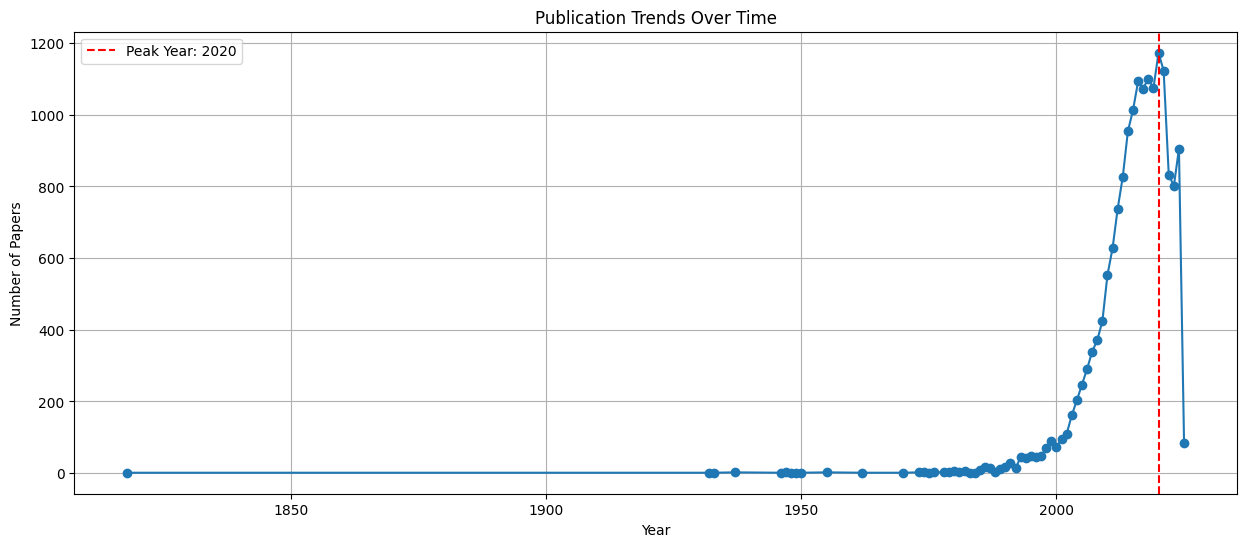

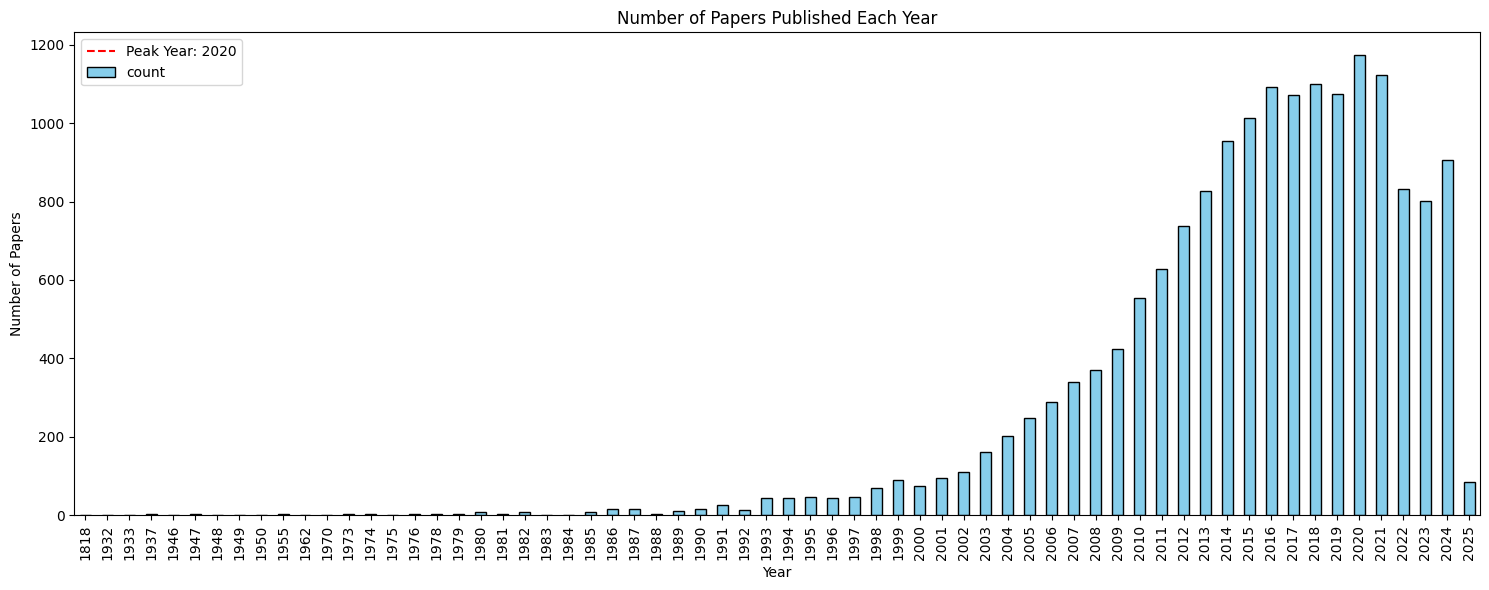

Publication year distribution saved to 'publication_year_distribution.csv'.
CPU times: user 2.02 s, sys: 783 ms, total: 2.8 s
Wall time: 1.81 s


In [6]:
%%time
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ##########################################################################

# Display dataset structure
print("Columns in dataset:", validated_df.columns)

# ------------------------------------------------------------
# 2. Extract and Clean Publication Years
# ------------------------------------------------------------
# Some rows might not have a publication year; handle these gracefully
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')

# Drop rows without valid years
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# ------------------------------------------------------------
# 3. Analyze Publication Year Distribution
# ------------------------------------------------------------
year_counts = validated_df['publication_year'].value_counts().sort_index()
print("\nNumber of publications per year:")
print(year_counts)

# Identify the year with the highest number of publications
peak_year = year_counts.idxmax()
peak_count = year_counts.max()
print(f"\nPeak Publication Year: {peak_year} with {peak_count} papers.")

# ------------------------------------------------------------
# 4. Visualize Publication Year Trends
# ------------------------------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('Publication Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.axvline(peak_year, color='red', linestyle='--', label=f'Peak Year: {peak_year}')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 5. Detailed Year Distribution Visualization
# ------------------------------------------------------------
plt.figure(figsize=(15, 6))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.axvline(peak_year, color='red', linestyle='--', label=f'Peak Year: {peak_year}')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6. Save Analysis Results
# ------------------------------------------------------------
year_counts.to_csv('publication_year_distribution.csv', header=['Number of Papers'])
print("Publication year distribution saved to 'publication_year_distribution.csv'.")


In [17]:
year_counts[2021]

1123

Columns in dataset: Index(['id', 'title', 'publication_year', 'abstract', 'topics',
       'referenced_works', 'source'],
      dtype='object')

Top 30 Most Prominent topics:
resilience and mental health: 5160
disaster management and resilience: 1983
supply chain resilience and risk management: 994
infrastructure resilience and vulnerability analysis: 987
regional resilience and development: 746
covid-19 and mental health: 634
optimism, hope, and well-being: 625
migration, health and trauma: 604
flood risk assessment and management: 598
family and disability support research: 577
child and adolescent psychosocial and emotional development: 536
health disparities and outcomes: 530
disaster response and management: 499
youth development and social support: 483
occupational health and safety research: 451
child abuse and trauma: 444
land use and ecosystem services: 413
climate change, adaptation, migration: 405
climate change impacts on agriculture: 401
psychological well-being and life s

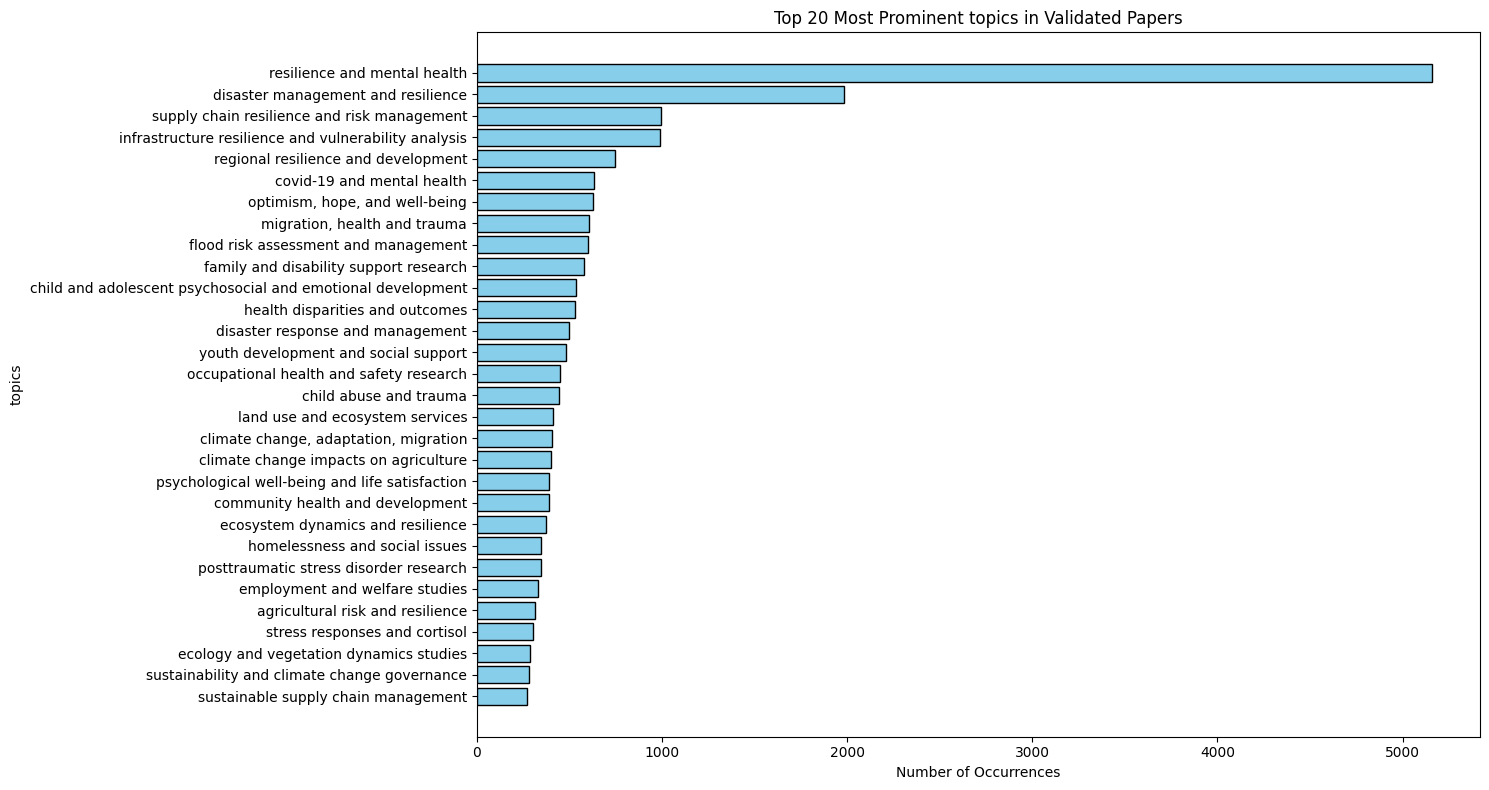

Top topics saved to 'top_topics.csv'.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################

# Display dataset structure
print("Columns in dataset:", validated_df.columns)

# ------------------------------------------------------------
# 2. Extract and Clean topics
# ------------------------------------------------------------
# Ensure 'topics' column contains lists
validated_df['topics'] = validated_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all topics into a single list
all_topics = [topics.strip().lower() for sublist in validated_df['topics'].dropna() for topics in sublist]

# Count topics occurrences
topics_counts = Counter(all_topics)
most_common_topics = topics_counts.most_common(30)  # Top 20 topics

# Display the most common topics
print("\nTop 30 Most Prominent topics:")
for topics, count in most_common_topics:
    print(f"{topics}: {count}")

# ------------------------------------------------------------
# 3. Visualize Top topics
# ------------------------------------------------------------
# Separate topics names and their counts
topics_names, topics_frequencies = zip(*most_common_topics)

# Bar Plot for Top topics
plt.figure(figsize=(15, 8))
plt.barh(topics_names[::-1], topics_frequencies[::-1], color='skyblue', edgecolor='black')
plt.title('Top 20 Most Prominent topics in Validated Papers')
plt.xlabel('Number of Occurrences')
plt.ylabel('topics')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Save topics Analysis Results
# ------------------------------------------------------------
topics_df = pd.DataFrame(most_common_topics, columns=['topics', 'Frequency'])
topics_df.to_csv('top_topics.csv', index=False)

print("Top topics saved to 'top_topics.csv'.")


Total papers before filtering: 16826
Total papers after filtering: 16826
Filtered dataset saved to 'filtered_social_resilience_papers.csv'.

Top 100 Most Prominent topics After Filtering:
resilience and mental health: 5160
disaster management and resilience: 1983
supply chain resilience and risk management: 994
infrastructure resilience and vulnerability analysis: 987
regional resilience and development: 746
covid-19 and mental health: 634
optimism, hope, and well-being: 625
migration, health and trauma: 604
flood risk assessment and management: 598
family and disability support research: 577


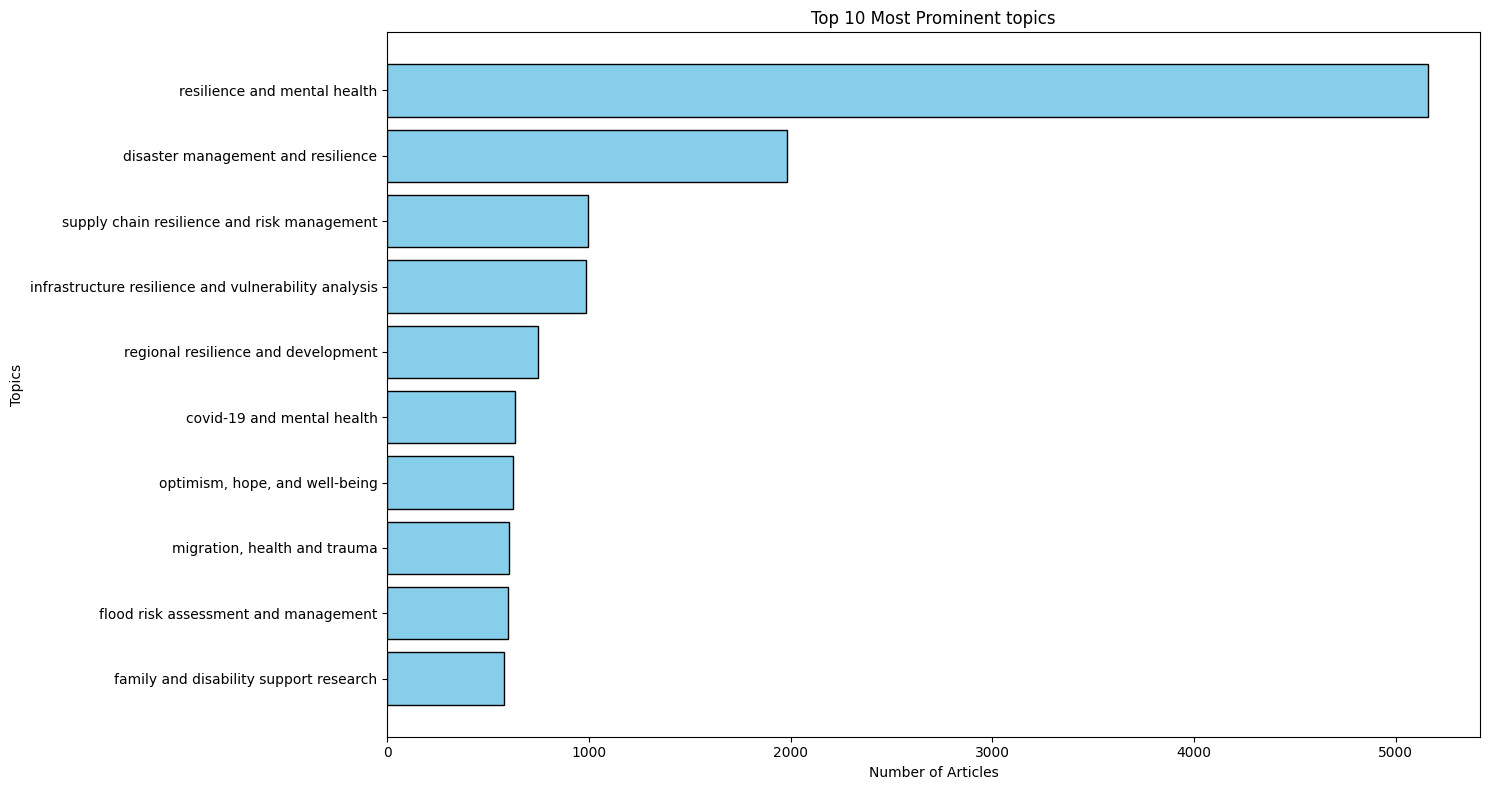

In [20]:
import pandas as pd
import ast

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################

# Ensure 'topics' column contains lists
validated_df['topics'] = validated_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# ------------------------------------------------------------
# 2. Define Relevant Social Resilience topics
# ------------------------------------------------------------
RELEVANT_topics = [
    "psychology",
    "psychological resilience",
    "social psychology",
    "political science",
    "sociology",
    "psychotherapist",
    "clinical psychology",
    "psychiatry",
    "developmental psychology",
    "social science",
    "social support"
]

# ------------------------------------------------------------
# 3. Filter Papers Based on Relevant topics
# ------------------------------------------------------------
def is_paper_relevant_by_topics(topics):
    """
    Check if any topics matches the relevant social resilience topics.
    """
    if not isinstance(topics, list):
        return False
    
    topics = [topics.strip().lower() for topics in topics]
    return any(topics in topics for topics in RELEVANT_topics)

# Apply filtering
filtered_df = validated_df  # [validated_df['topics'].apply(is_paper_relevant_by_topics)]

# Log the results
print(f"Total papers before filtering: {len(validated_df)}")
print(f"Total papers after filtering: {len(filtered_df)}")

# ------------------------------------------------------------
# 4. Save the Filtered Dataset
# ------------------------------------------------------------
filtered_df.to_csv('filtered_social_resilience_papers.csv', index=False)
print("Filtered dataset saved to 'filtered_social_resilience_papers.csv'.")

# ------------------------------------------------------------
# 5. Analyze Top topics Again
# ------------------------------------------------------------
from collections import Counter

# Flatten all topics in the filtered dataset
all_topics = [topics.strip().lower() for sublist in filtered_df['topics'].dropna() for topics in sublist]

# Count topics occurrences
topics_counts = Counter(all_topics)
most_common_topics = topics_counts.most_common(10)

batch_size = 100
total_topics = len(most_common_topics)

for i in range(0, total_topics, batch_size):
    # Print different header for the first batch vs. subsequent batches if needed
    if i == 0:
        print("\nTop 100 Most Prominent topics After Filtering:")
    else:
        print("\nNext 100 Most Prominent topics After Filtering:")
    
    # Print the current batch of topics
    for topic, count in most_common_topics[i:i + batch_size]:
        print(f"{topic}: {count}")


# ------------------------------------------------------------
# 6. Visualize Filtered topics
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Separate topics names and their counts
topics_names, topics_frequencies = zip(*most_common_topics)

# Bar Plot for Top topics
plt.figure(figsize=(15, 8))
plt.barh(topics_names[::-1], topics_frequencies[::-1], color='skyblue', edgecolor='black')
plt.title('Top 10 Most Prominent topics')
plt.xlabel('Number of Articles')
plt.ylabel('Topics')
plt.tight_layout()
plt.show()

# Social Concpets as extracted from the top 30 concepts of papers (As provided by OpenAlex)
social_concepts = [
    "psychology",
    'psychological resilience',
    'social psychology',
    'political science',
    'sociology',
    'psychotherapist',
    'clinical psychology',
    'psychiatry',
    'developmental psychology',
    'social science',
    'social support'
]



Social Topics as extracted by ChatGPT o3-mini-high from a list of the 500 most prominent topics.
ChatGPT's definition of 'social resilience' was very broad first.

In [9]:
unfiltered_social_topics = [
    "resilience and mental health",
    "disaster management and resilience",
    "covid-19 and mental health",
    "optimism, hope, and well-being",
    "migration, health and trauma",
    "family and disability support research",
    "child and adolescent psychosocial and emotional development",
    "health disparities and outcomes",
    "disaster response and management",
    "youth development and social support",
    "child abuse and trauma",
    "psychological well-being and life satisfaction",
    "community health and development",
    "homelessness and social issues",
    "posttraumatic stress disorder research",
    "employment and welfare studies",
    "education and learning interventions",
    "psychosocial factors impacting youth",
    "grit, self-efficacy, and motivation",
    "early childhood education and development",
    "health and well-being studies",
    "health, psychology, and well-being",
    "childhood cancer survivors' quality of life",
    "family support in illness",
    "community development and social impact",
    "health and wellbeing research",
    "social work education and practice",
    "innovation and socioeconomic development",
    "covid-19 pandemic impacts",
    "poverty, education, and child welfare",
    "food security and health in diverse populations",
    "urban and rural development challenges",
    "lgbtq health, identity, and policy",
    "grief, bereavement, and mental health",
    "child welfare and adoption",
    "peacebuilding and international security",
    "suicide and self-harm studies",
    "mindfulness and compassion interventions",
    "mental health treatment and access",
    "intergenerational family dynamics and caregiving",
    "urban green space and health",
    "religion, spirituality, and psychology",
    "urban transport and accessibility",
    "indigenous studies and ecology",
    "child nutrition and water access",
    "cancer survivorship and care",
    "workplace health and well-being",
    "public relations and crisis communication",
    "environmental and social impact assessments",
    "social capital and networks",
    "youth education and societal dynamics",
    "family caregiving in mental illness",
    "racial and ethnic identity research",
    "mental health research topics",
    "social policy and reform studies",
    "evacuation and crowd dynamics",
    "facility location and emergency management",
    "global security and public health",
    "maternal mental health during pregnancy and postpartum",
    "indigenous health, education, and rights",
    "bullying, victimization, and aggression",
    "housing, finance, and neoliberalism",
    "innovative approaches in technology and social development",
    "education and experiences of immigrants and refugees",
    "international development and aid",
    "rural development and sustainability",
    "aging and gerontology research",
    "health and conflict studies",
    "long-term effects of covid-19",
    "urban, neighborhood, and segregation studies",
    "child nutrition and feeding issues",
    "corporate social responsibility reporting",
    "cultural heritage management and preservation",
    "korean urban and social studies",
    "student stress and coping",
    "french urban and social studies",
    "religion, society, and development",
    "emotional intelligence and performance",
    "social sciences and governance",
    "opinion dynamics and social influence",
    "regional development and policy",
    "intimate partner and family violence",
    "tourism, volunteerism, and development",
    "income, poverty, and inequality",
    "microfinance and financial inclusion",
    "mental health and patient involvement",
    "education discipline and inequality",
    "attachment and relationship dynamics",
    "educational systems and policies",
    "family dynamics and relationships",
    "urban planning and governance",
    "social media and politics",
    "art therapy and mental health",
    "public health and nutrition",
    "crime, illicit activities, and governance",
    "hiv, drug use, sexual risk",
    "misinformation and its impacts",
    "anxiety, depression, psychometrics, treatment, cognitive processes",
    "cambodian history and society",
    "child development and education",
    "educational methods and impacts",
    "digital mental health interventions",
    "criminal justice and corrections analysis",
    "migration, refugees, and integration",
    "banking, crisis management, covid-19 impact",
    "urban design and spatial analysis",
    "occupational therapy practice and research",
    "education practices and challenges",
    "youth substance use and school attendance",
    "environmental and cultural studies in latin america and beyond",
    "global socioeconomic and political dynamics",
    "identity, memory, and therapy",
    "health policy implementation science",
    "death anxiety and social exclusion",
    "aging, elder care, and social issues",
    "quality and safety in healthcare",
    "vietnamese history and culture studies",
    "china's socioeconomic reforms and governance",
    "nutrition and health in aging",
    "disability education and employment",
    "mental health via writing",
    "environmental justice and health disparities",
    "crime patterns and interventions",
    "teacher education and leadership studies",
    "labor market and education",
    "interprofessional education and collaboration",
    "regional development and environment",
    "service-learning and community engagement",
    "global maternal and child health",
    "cooperative studies and economics",
    "global health care issues",
    "cultural industries and urban development",
    "environmental education and sustainability",
    "adolescent sexual and reproductive health",
    "food security and socioeconomic dynamics",
    "psychology of development and education",
    "natural resources and economic development",
    "place attachment and urban studies",
    "social and intergroup psychology",
    "substance abuse treatment and outcomes",
    "children's rights and participation",
    "european union policy and governance",
    "financial literacy, pension, retirement analysis",
    "occupational health and performance",
    "middle east and rwanda conflicts",
    "land rights and reforms",
    "higher education research studies",
    "labor movements and unions",
    "stress and burnout research",
    "parental involvement in education",
    "leadership, courage, and heroism studies",
    "career development and diversity",
    "african studies and sociopolitical issues",
    "viral infections and outbreaks research",
    "climate change policy and economics",
    "global trade, sustainability, and social impact",
    "workplace violence and bullying",
    "child therapy and development",
    "climate change communication and perception",
    "digital marketing and social media",
    "workplace spirituality and leadership",
    "outdoor and experiential education",
    "global financial crisis and policies",
    "nursing education and management",
    "migration, ethnicity, and economy",
    "hiv/aids impact and responses",
    "political economy and marxism",
    "behavioral health and interventions",
    "education and character development",
    "education and islamic studies",
    "sex work and related issues",
    "eating disorders and behaviors",
    "education and critical thinking development",
    "southeast asian sociopolitical studies",
    "politics and conflicts in afghanistan, pakistan, and middle east",
    "school health and nursing education",
    "healthcare cost, quality, practices",
    "counseling, therapy, and family dynamics",
    "education systems and policy",
    "local governance and development",
    "education, achievement, and giftedness",
    "nonprofit sector and volunteering",
    "sociopolitical dynamics in russia",
    "global health workforce issues",
    "music therapy and health",
    "prenatal substance exposure effects",
    "hate speech and cyberbullying detection",
    "urbanization and city planning",
    "cultural differences and values",
    "child and adolescent health",
    "gender, security, and conflict",
    "regional socio-economic development trends",
    "mental health and well-being",
    "anthropological studies and insights",
    "elder abuse and neglect",
    "mental health and psychiatry",
    "public health policies and education",
    "gender, feminism, and media",
    "health, environment, cognitive aging",
    "retirement, disability, and employment"
]

# Refined social resilience related topics

The refinement was based on the following social resilience explanation:
"Social resilience is defined as the capacity of groups or communities to cope with external stresses and disturbances resulting from social, political, and environmental changes. It is closely linked to ecological resilience, which refers to ecosystems' ability to maintain themselves despite disturbances. However, the relationship between social and ecological resilience is complex, particularly for communities dependent on ecological resources for their livelihoods. Social resilience is characterized as a dynamic, multi-level, and evolutionary process that enables societies to not only cope with adversity but also adapt and transform themselves."


In [10]:
social_topics = [
    "resilience and mental health",
    "disaster management and resilience",
    "covid-19 and mental health",
    "optimism, hope, and well-being",
    "migration, health and trauma",
    "family and disability support research",
    "child and adolescent psychosocial and emotional development",
    "health disparities and outcomes",
    "disaster response and management",
    "youth development and social support",
    "psychological well-being and life satisfaction",
    "community health and development",
    "homelessness and social issues",
    "posttraumatic stress disorder research",
    "employment and welfare studies",
    "education and learning interventions",
    "psychosocial factors impacting youth",
    "grit, self-efficacy, and motivation",
    "early childhood education and development",
    "health and well-being studies",
    "health, psychology, and well-being",
    "family support in illness",
    "community development and social impact",
    "health and wellbeing research",
    "social work education and practice",
    "innovation and socioeconomic development",
    "covid-19 pandemic impacts",
    "poverty, education, and child welfare",
    "food security and health in diverse populations",
    "urban and rural development challenges",
    "lgbtq health, identity, and policy",
    "grief, bereavement, and mental health",
    "child welfare and adoption",
    "peacebuilding and international security",
    "mindfulness and compassion interventions",
    "mental health treatment and access",
    "intergenerational family dynamics and caregiving",
    "urban green space and health",
    "religion, spirituality, and psychology",
    "child nutrition and water access",
    "workplace health and well-being",
    "public relations and crisis communication",
    "environmental and social impact assessments",
    "social capital and networks",
    "youth education and societal dynamics",
    "family caregiving in mental illness",
    "racial and ethnic identity research",
    "mental health research topics",
    "social policy and reform studies",
    "evacuation and crowd dynamics",
    "facility location and emergency management",
    "global security and public health",
    "maternal mental health during pregnancy and postpartum",
    "indigenous health, education, and rights",
    "bullying, victimization, and aggression",
    "housing, finance, and neoliberalism",
    "innovative approaches in technology and social development",
    "education and experiences of immigrants and refugees",
    "international development and aid",
    "rural development and sustainability",
    "aging and gerontology research",
    "health and conflict studies",
    "long-term effects of covid-19",
    "urban, neighborhood, and segregation studies",
    "child nutrition and feeding issues",
    "corporate social responsibility reporting",
    "cultural heritage management and preservation",
    "korean urban and social studies",
    "student stress and coping",
    "french urban and social studies",
    "religion, society, and development",
    "social sciences and governance",
    "opinion dynamics and social influence",
    "regional development and policy",
    "intimate partner and family violence",
    "tourism, volunteerism, and development",
    "income, poverty, and inequality",
    "microfinance and financial inclusion",
    "mental health and patient involvement",
    "education discipline and inequality",
    "attachment and relationship dynamics",
    "educational systems and policies",
    "family dynamics and relationships",
    "urban planning and governance",
    "social media and politics",
    "art therapy and mental health",
    "public health and nutrition",
    "crime, illicit activities, and governance",
    "hiv, drug use, sexual risk",
    "misinformation and its impacts",
    "anxiety, depression, psychometrics, treatment, cognitive processes",
    "child development and education",
    "educational methods and impacts",
    "digital mental health interventions",
    "criminal justice and corrections analysis",
    "migration, refugees, and integration",
    "banking, crisis management, covid-19 impact",
    "urban design and spatial analysis",
    "education practices and challenges",
    "environmental and cultural studies in latin america and beyond",
    "global socioeconomic and political dynamics",
    "identity, memory, and therapy",
    "health policy implementation science",
    "death anxiety and social exclusion",
    "aging, elder care, and social issues",
    "quality and safety in healthcare",
    "china's socioeconomic reforms and governance",
    "nutrition and health in aging",
    "disability education and employment",
    "mental health via writing",
    "environmental justice and health disparities",
    "crime patterns and interventions",
    "teacher education and leadership studies",
    "labor market and education",
    "interprofessional education and collaboration",
    "regional development and environment",
    "service-learning and community engagement",
    "global maternal and child health",
    "cooperative studies and economics",
    "global health care issues",
    "cultural industries and urban development",
    "environmental education and sustainability",
    "adolescent sexual and reproductive health",
    "food security and socioeconomic dynamics",
    "psychology of development and education",
    "natural resources and economic development",
    "place attachment and urban studies",
    "social and intergroup psychology",
    "substance abuse treatment and outcomes",
    "children's rights and participation",
    "european union policy and governance",
    "financial literacy, pension, retirement analysis",
    "occupational health and performance",
    "middle east and rwanda conflicts",
    "land rights and reforms",
    "higher education research studies",
    "labor movements and unions",
    "stress and burnout research",
    "parental involvement in education",
    "leadership, courage, and heroism studies",
    "career development and diversity",
    "african studies and sociopolitical issues",
    "viral infections and outbreaks research",
    "climate change policy and economics",
    "global trade, sustainability, and social impact",
    "workplace violence and bullying",
    "child therapy and development",
    "climate change communication and perception",
    "digital marketing and social media",
    "workplace spirituality and leadership",
    "outdoor and experiential education",
    "global financial crisis and policies",
    "nursing education and management"
]


<ipython-input-11-81442fcf393e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


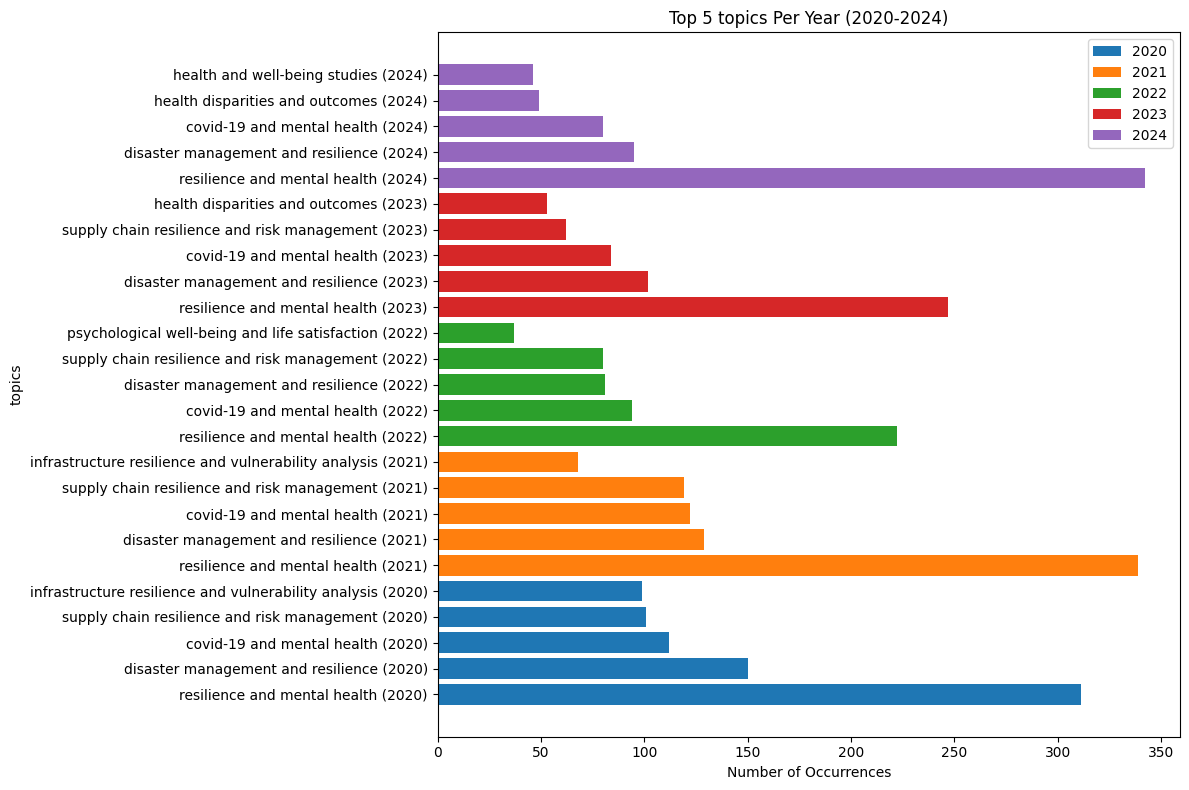

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load Validated Data
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################


# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 2020-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 2020) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Find Top 5 topics Per Year
years = filtered_df['publication_year'].unique()
top_topics_per_year = {}

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    all_topics = [topics.strip().lower() for sublist in yearly_df['topics'].dropna() for topics in sublist]
    topics_counts = Counter(all_topics)
    top_topics_per_year[year] = topics_counts.most_common(5)

# Visualization
plt.figure(figsize=(12, 8))
for year, topics in top_topics_per_year.items():
    topics_names, topics_frequencies = zip(*topics)
    plt.barh([f"{topics} ({year})" for topics in topics_names], topics_frequencies, label=f"{year}")

plt.title('Top 5 topics Per Year (2020-2024)')
plt.xlabel('Number of Occurrences')
plt.ylabel('topics')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-12-5246b4d5d269>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


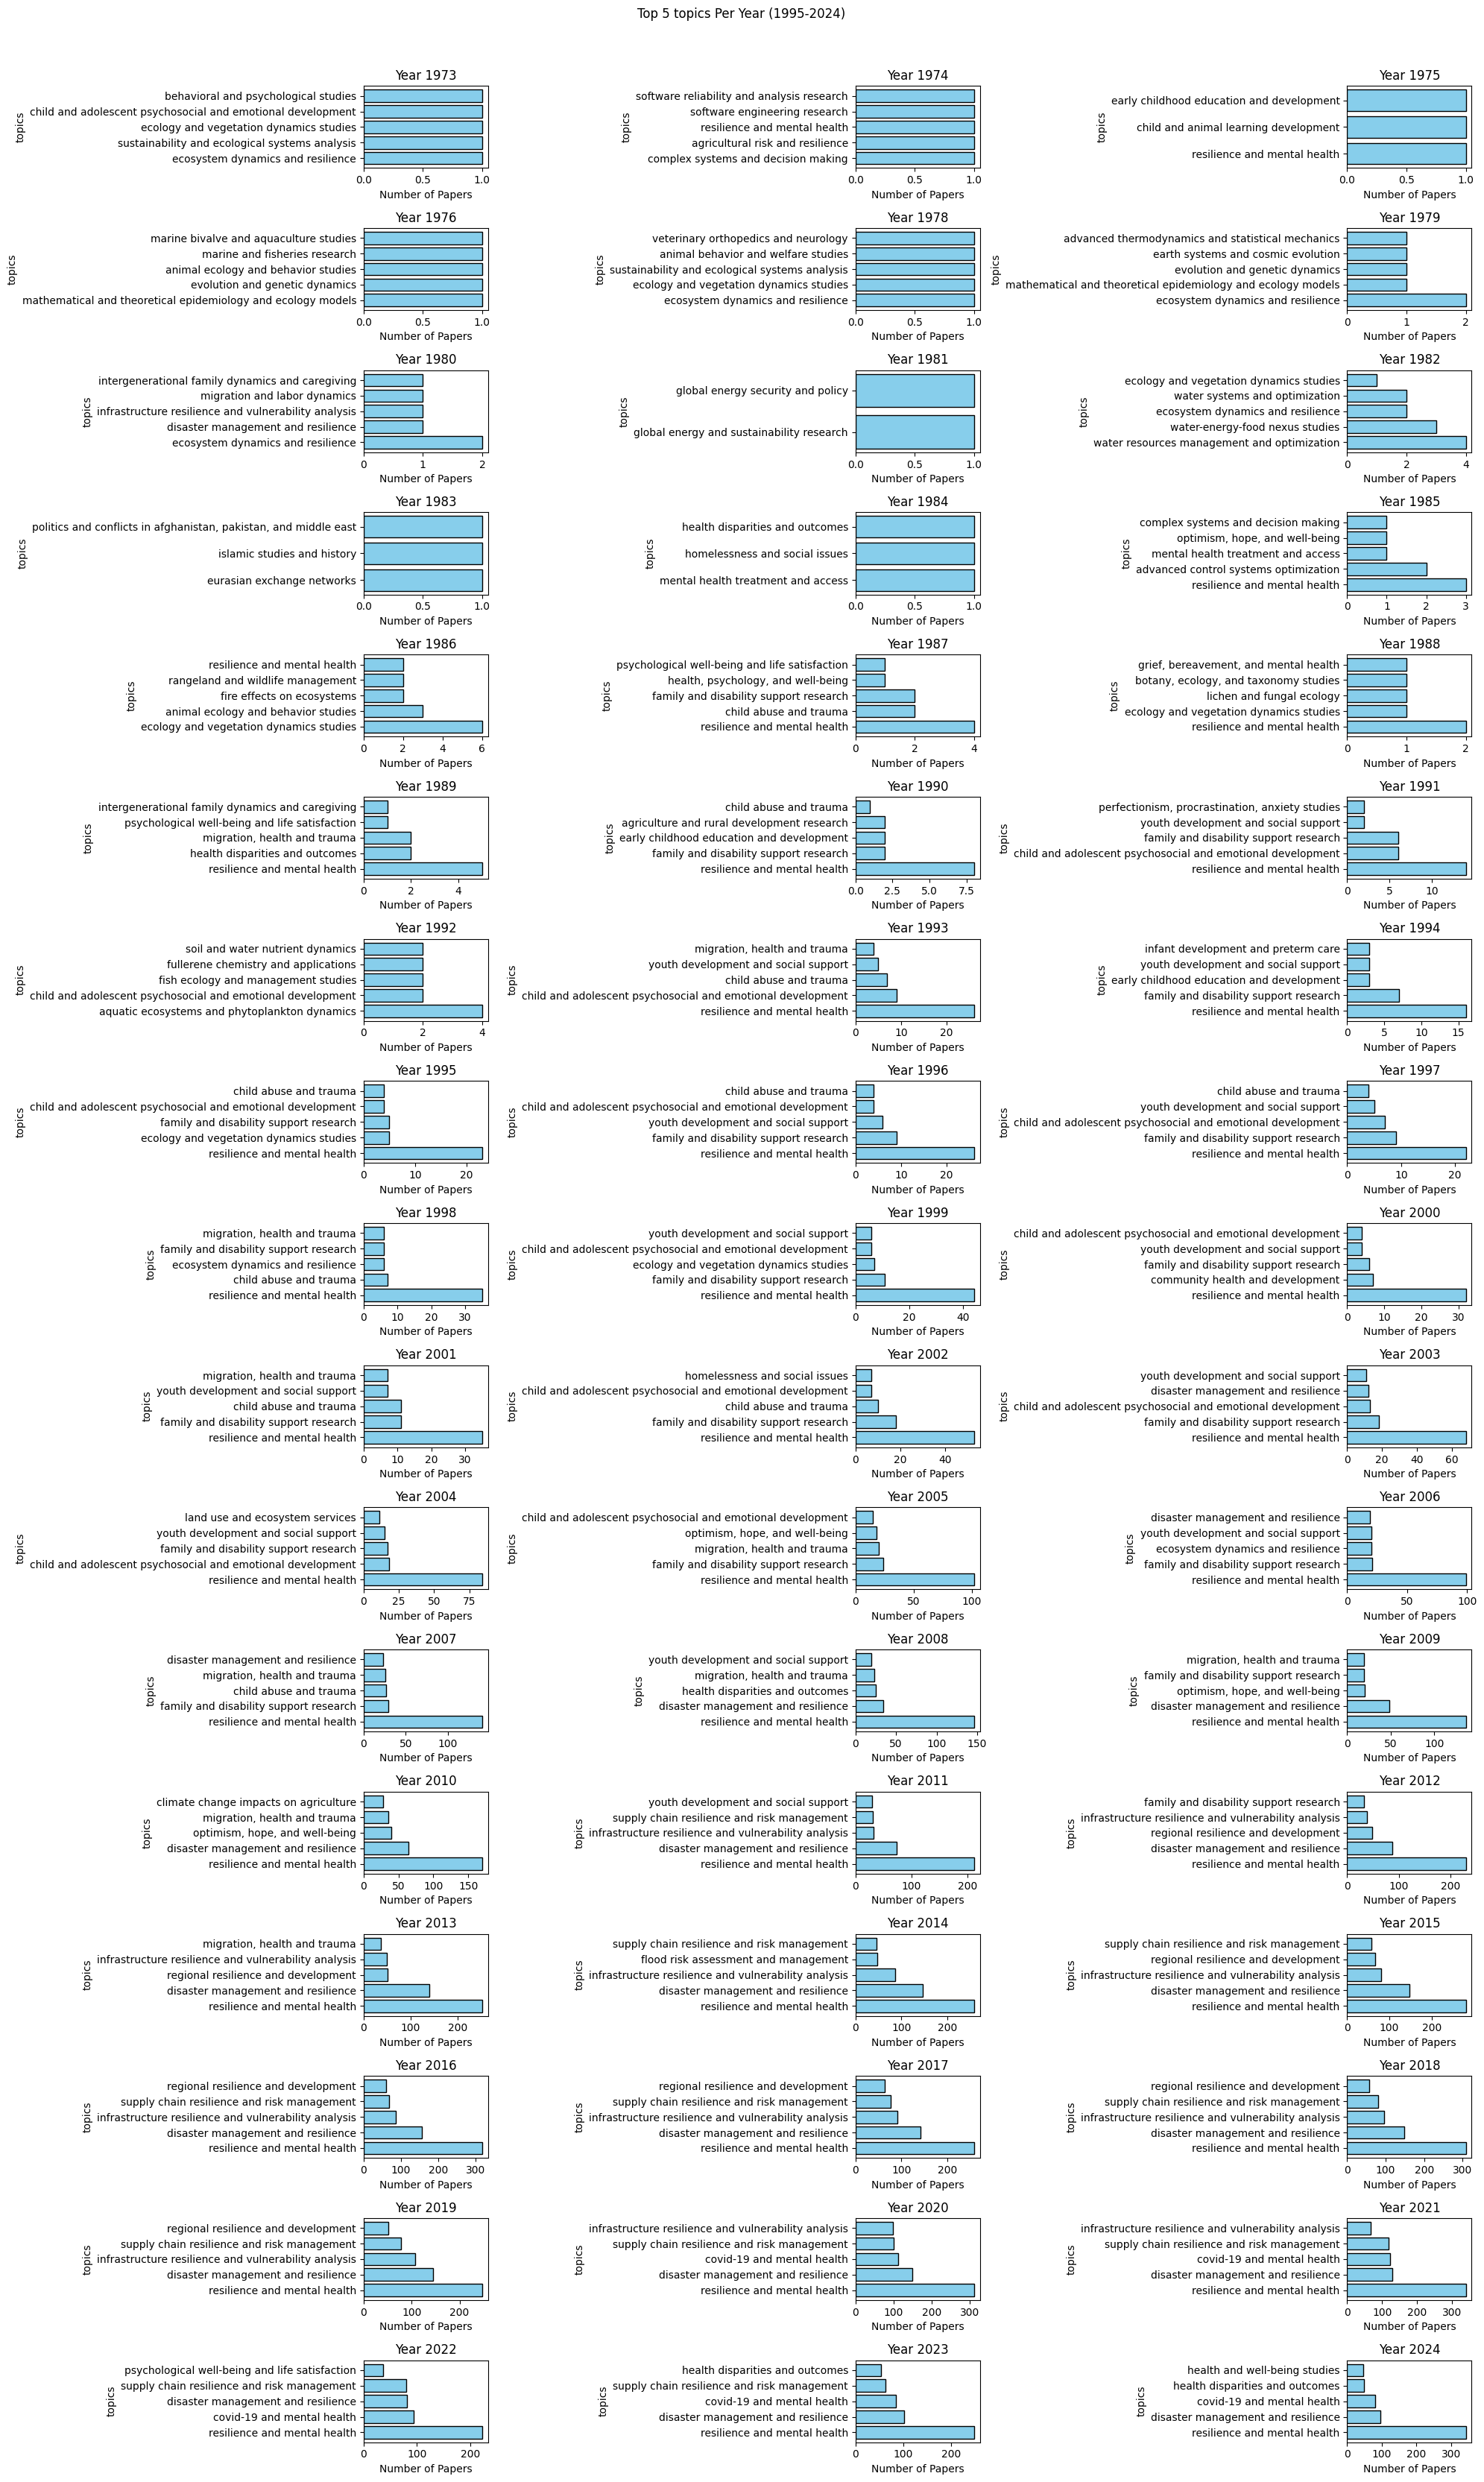

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 1995-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 1973) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Find Top 5 topics Per Year
years = sorted(filtered_df['publication_year'].unique())
top_topics_per_year = {}

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    all_topics = [topics.strip().lower() for sublist in yearly_df['topics'].dropna() for topics in sublist]
    topics_counts = Counter(all_topics)
    top_topics_per_year[year] = topics_counts.most_common(5)

# Visualization
fig, axes = plt.subplots(17, 3, figsize=(20, 35))
fig.suptitle('Top 5 topics Per Year (1995-2024)')

for idx, year in enumerate(years):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    if year in top_topics_per_year:
        topics_names, topics_frequencies = zip(*top_topics_per_year[year])
        ax.barh(topics_names, topics_frequencies, color='skyblue', edgecolor='black')
        ax.set_title(f'Year {year}')
        ax.set_xlabel('Number of Papers')
        ax.set_ylabel('topics')
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


<ipython-input-13-b90c4cdec6ef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


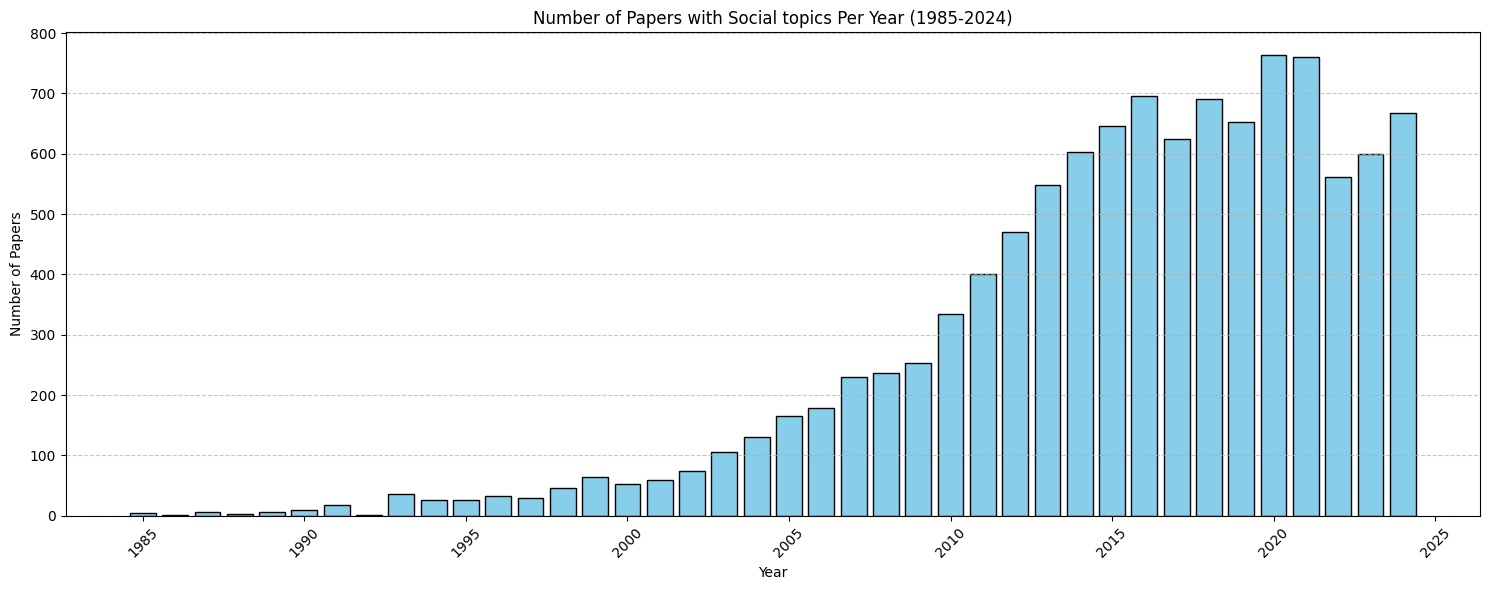

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load Validated Data
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################


# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 1985-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 1985) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Count Papers Containing Social topics Per Year
years = sorted(filtered_df['publication_year'].unique())
social_topics_per_year = {year: 0 for year in years}
total_papers_per_year = filtered_df['publication_year'].value_counts().to_dict()

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    count = 0
    for topics in yearly_df['topics'].dropna():
        if any(topics.lower().strip() in social_topics for topics in topics):
            count += 1
    social_topics_per_year[year] = count

# Plot absolute number of papers with social topics
plt.figure(figsize=(15, 6))
plt.bar(social_topics_per_year.keys(), social_topics_per_year.values(), color='skyblue', edgecolor='black')
plt.title('Number of Papers with Social topics Per Year (1985-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


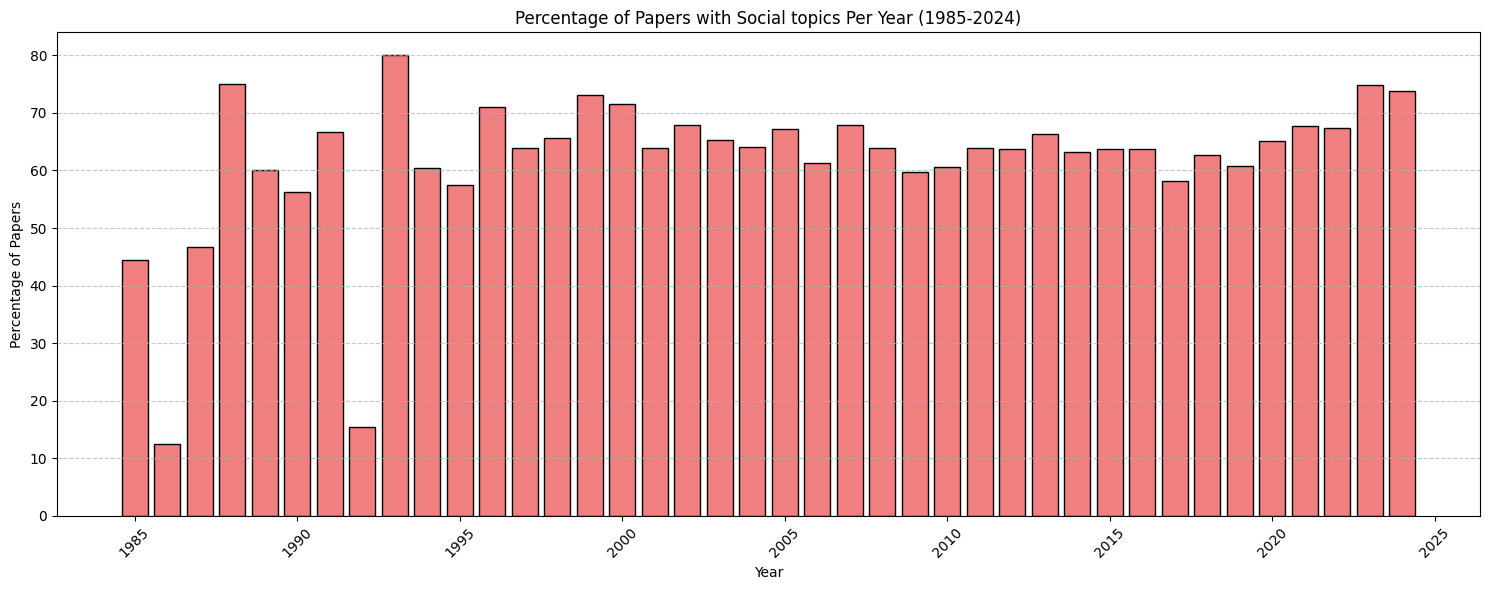

In [14]:
# Calculate and plot percentage of papers with social topics per year
percent_social_topics_per_year = {
    year: (social_topics_per_year[year] / total_papers_per_year.get(year, 1)) * 100
    for year in years
}
 
plt.figure(figsize=(15, 6))
plt.bar(percent_social_topics_per_year.keys(), percent_social_topics_per_year.values(), color='lightcoral', edgecolor='black')
plt.title('Percentage of Papers with Social topics Per Year (1985-2024)')
plt.xlabel('Year')
plt.ylabel('Percentage of Papers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
